In [1]:
%pylab inline
%config InlineBackend.figure_format ='retina'

import glob
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
def latex_on_mac_only():
    import sys
    if sys.executable == '/Users/kwhuang/anaconda3/bin/python':    # on Mac
        from matplotlib import rc
        rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
        rc('text', usetex=True)

In [3]:
latex_on_mac_only()

In [4]:
lw = 3

In [5]:
def m2M(m, d):
    return m - 5.*np.log10(d) + 5.

def Lv2Mv(Lv):
    """ convert Lv to Mv in the unit of L_sun """
    Mv_sun = 4.83
    return Mv_sun - 2.5 * np.log10(Lv)

def Mv2Lv(Mv):
    Mvsun = 4.83
    return  10**(-0.4*(Mv - Mvsun))

In [6]:
betw = lambda x, x1, x2: (x >= x1) & (x < x2)

# Compare the IMFs

In [7]:
import imf as iimf
from isochrones.priors import ChabrierPrior

nsample = int(1e7)
mass_iso = ChabrierPrior().sample(nsample)
mass_iimf = iimf.Chabrier().distr.rvs(nsample)

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


1.2278463882111605


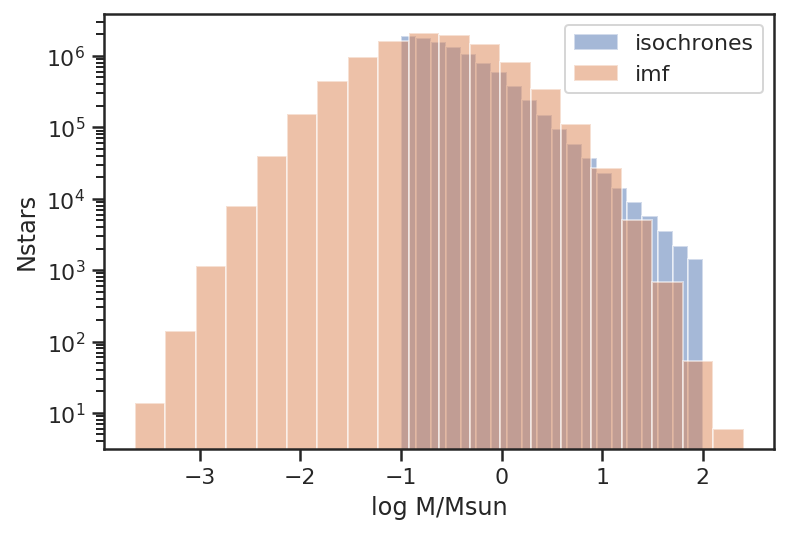

In [8]:
sns.set(style="white", color_codes=True, font_scale=1)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

ax.hist(np.log10(mass_iso), bins=20, alpha=0.5, label='isochrones')
ax.hist(np.log10(mass_iimf), bins=20, alpha=0.5, label='imf')

print(mass_iso.sum() / mass_iimf.sum())

ax.set_yscale('log')
ax.set_xlabel('log M/Msun')
ax.set_ylabel('Nstars')
ax.legend()

# Sample the IMF

In [9]:
import imf as iimf

nsample = int(1e7)
mass_sample = iimf.Chabrier().distr.rvs(nsample)
# mass_sample = ChabrierPrior().sample(nsample)

# Interpolate the isochrone manually

In [10]:
def scipy_inter_iso(mini, mag, mini_sample):
    """ Interpolate the magnitude manually with scipy
    : mini : initial mass from database
    : mag : magnitude from database
    : mini_sample : initial mass samples
    """
    import scipy.interpolate 
    INTERPOLATE = scipy.interpolate.UnivariateSpline(mini, mag, s=0, k=1, ext=1)
    pred_mag = INTERPOLATE(mini_sample)
    return  pred_mag[pred_mag != 0]

In [11]:
import sqlutilpy as sqlutil

sql_str = '''
    select  mini, gmag, g_bpmag, g_rpmag
    from  isochrones.gaia_1804 
    where age=12000000000 and feh=-2.0
    '''

mini, gmag, g_bpmag, g_rpmag = sqlutil.get(sql_str, host='wsdb.hpc1.cs.cmu.edu', user='kuan_wei', password=']VxyR1do')

mini[113] = mini[113] + 1e-10

In [12]:
pred_gmag = scipy_inter_iso(mini, gmag, mass_sample)
pred_g_bpmag = scipy_inter_iso(mini, g_bpmag, mass_sample)
pred_g_rpmag = scipy_inter_iso(mini, g_rpmag, mass_sample)

In [13]:
bp_rp_scipy = pred_g_bpmag - pred_g_rpmag
g_scipy = pred_gmag

Text(0, 0.5, 'G')

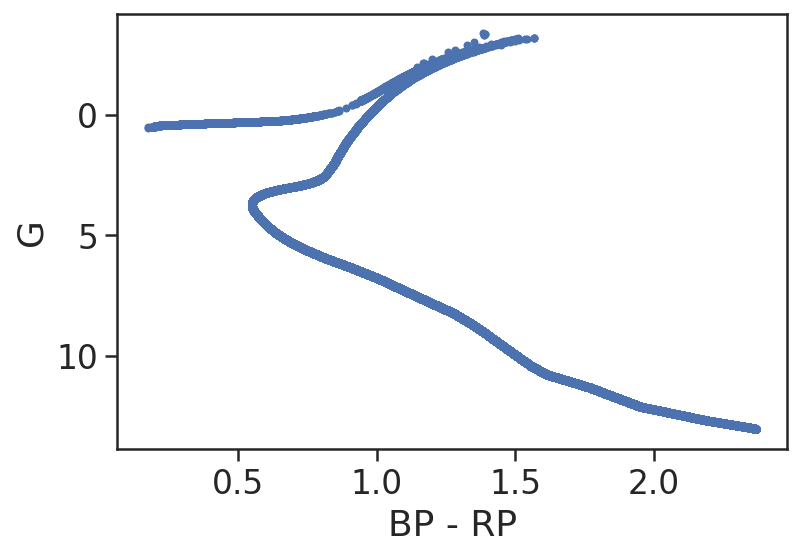

In [14]:
sns.set(style="white", color_codes=True, font_scale=1.5)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

ax.plot(bp_rp_scipy, g_scipy, '.')

ax.invert_yaxis()
ax.set_xlabel('BP - RP')
ax.set_ylabel('G')

In [15]:
dmgrid = np.arange(15, 25, 0.1)
nstar_betw_scipy = np.array([betw(pred_gmag + dmgrid[i], 17, 21).sum() for i in range(len(dmgrid))])

Text(0, 0.5, 'Nstars: 17 < G <21')

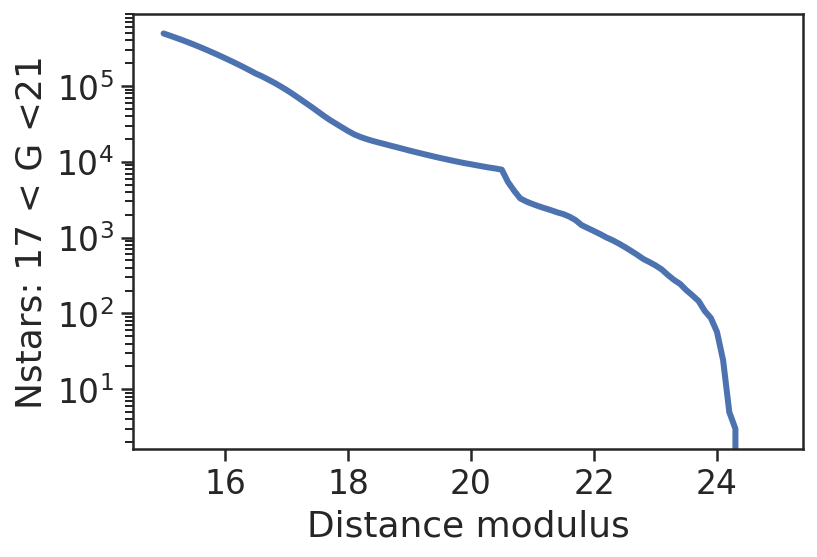

In [16]:
sns.set(style="white", color_codes=True, font_scale=1.5)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

ax.semilogy(dmgrid, nstar_betw_scipy, lw=lw)

ax.set_xlabel('Distance modulus')
ax.set_ylabel('Nstars: 17 < G <21')

# Interpolate the isochrone with the isochrones package

In [17]:
FEH = -2    # log10(z / zsun) = 1e-3
AGE = np.log10(12e9)  # np.log10(12 Gyr)

In [18]:
from isochrones import get_ichrone

tracks = get_ichrone('mist', tracks=True, bands=['V', 'G', 'BP', 'RP'])
df = tracks.generate(mass_sample, AGE, FEH, accurate=True, return_nan=True)
df = df.dropna()
df.head(2)

,radius,logTeff,feh,logL,nu_max,density,eep,initial_mass,Teff,mass,...,age,dt_deep,V_mag,G_mag,BP_mag,RP_mag,distance,AV,initial_feh,requested_age
0,0.170373,3.591254,-1.971489,-2.221540,20793.783403,46.281692,267.493629,0.159073,3901.938535,0.159069,...,10.079181,0.021728,11.204691,10.656311,11.476440,9.797620,10,0,-2,10.079181
1,0.319972,3.619854,-1.971490,-1.555727,12443.408135,15.021333,303.829479,0.349053,4167.292955,0.349040,...,10.079181,0.018494,9.305502,8.891441,9.578952,8.101865,10,0,-2,10.079181


In [19]:
df = df[['V_mag', 'G_mag', 'BP_mag', 'RP_mag']]
df = df.dropna()
df.head(2)

,V_mag,G_mag,BP_mag,RP_mag
0,11.204691,10.656311,11.476440,9.797620
1,9.305502,8.891441,9.578952,8.101865


In [20]:
bp_rp_iso = df['BP_mag'] - df['RP_mag']
g_iso = df['G_mag']

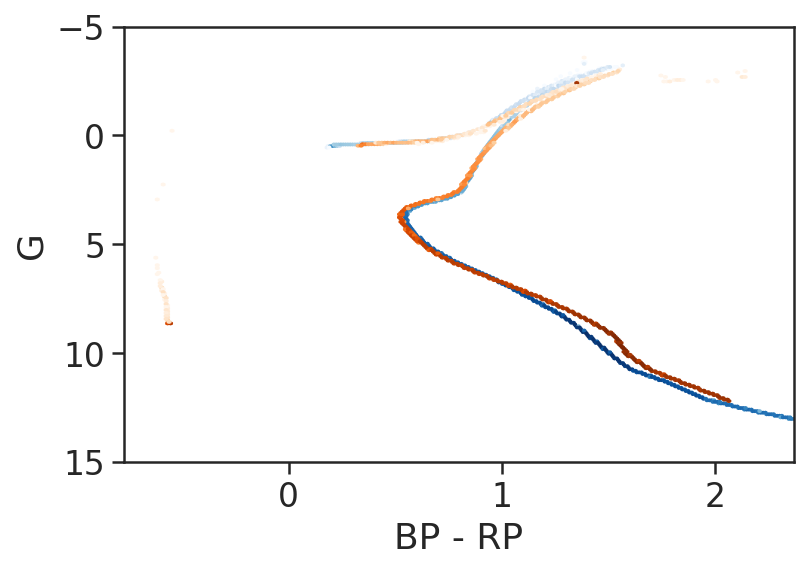

In [44]:
sns.set(style="white", color_codes=True, font_scale=1.5)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

# ax.plot(bp_rp_scipy, g_scipy, '.', label='scipy')
# ax.plot(bp_rp_iso, g_iso, '.', label='iso')

ax.hexbin(bp_rp_scipy, g_scipy, label='scipy', mincnt=1, cmap='Blues', bins='log', gridsize=200)
ax.hexbin(bp_rp_iso, g_iso, label='iso', mincnt=1, cmap='Oranges', bins='log', gridsize=200)

ax.set_xlabel('BP - RP')
ax.set_ylabel('G')
ax.set_ylim([15, -5])
# ax.legend()

savefig('plots/acc_cmds.pdf', bbox_inches='tight')

In [45]:
print(len(g_iso), len(g_scipy))

Mtot_iso = Lv2Mv(sum(Mv2Lv(g_iso)))
Mtot_scipy = Lv2Mv(sum(Mv2Lv(g_scipy)))

print(Mtot_iso, Mtot_scipy)

5684004 5794589
-13.602413144470896 -11.026025443431562


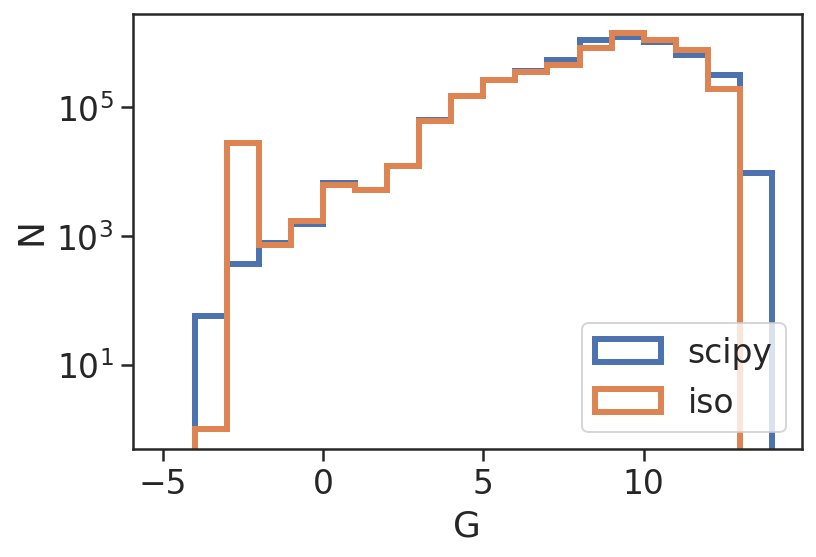

In [53]:
sns.set(style="white", color_codes=True, font_scale=1.5)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

bins = range(-5, 15)

ax.hist(g_scipy, label='scipy', histtype='step', lw=lw, bins=bins)
ax.hist(g_iso, label='iso', histtype='step', lw=lw, bins=bins)

ax.set_yscale('log')
ax.set_xlabel('G')
ax.set_ylabel('N')
ax.legend(loc=4)

savefig('plots/acc_hist_g.pdf', bbox_inches='tight')

In [47]:
nstar_betw_iso = np.array([betw(df['G_mag'] + dmgrid[i], 17, 21).sum() for i in range(len(dmgrid))])

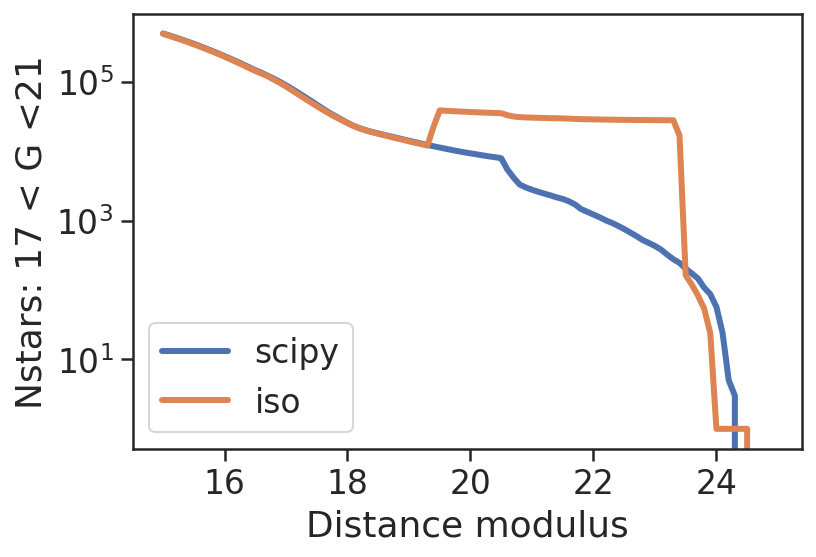

In [48]:
sns.set(style="white", color_codes=True, font_scale=1.5)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

ax.semilogy(dmgrid, nstar_betw_scipy, lw=lw, label='scipy')
ax.semilogy(dmgrid, nstar_betw_iso, lw=lw, label='iso')

ax.set_xlabel('Distance modulus')
ax.set_ylabel('Nstars: 17 < G <21')
ax.legend()

savefig('plots/acc_dm_nstar.pdf', bbox_inches='tight')

In [26]:
# from isochrones import get_ichrone

# nsample = int(1e5)
# mass_sample = iimf.Chabrier().distr.rvs(nsample)

# tracks = get_ichrone('mist', tracks=True, bands=['V', 'G', 'BP', 'RP'])
# df = tracks.generate(mass_sample, AGE, FEH, accurate=True, return_nan=True)
# df = df.dropna()
# df.head(2)

In [27]:
stop

NameError: name 'stop' is not defined

In [ ]:
def m2m(m0, d0, d):
    return m0 + 5. * np.log10(d / d0)

def dm(d):    # d in pc
    return 5. * np.log10(d / 10.)

In [ ]:
path_csvs = glob.glob('sim_gc_csv/*')
print(path_csvs)

In [ ]:
gcid = 1
print(path_csvs[gcid])

In [ ]:
iso_cols=['G_mag', 'BP_mag', 'RP_mag', 'Mbol', 'V_mag', 'mass', 'initial_mass']

df_isochrone = pd.read_csv(path_csvs[gcid], usecols=iso_cols)
df_isochrone.head(2)

In [ ]:
d0 = 1e3    # 1 kpc
dgrid = np.logspace(4, 6, 100)    # dist in pc [1e1, 1e6]
dmgrid = dm(dgrid)    # dist modulus 

In [ ]:
nstars = []
for d in dgrid:
    magd = m2m(df_isochrone['G_mag'].values, d0, d)
    nstar = sum((17. < magd) & (magd < 21.))
    nstars.append(nstar)
nstars = np.array(nstars)

In [ ]:
sns.set(style="white", color_codes=True, font_scale=1)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

print(dm(10e3), dm(100e3))

ax.plot(dmgrid, nstars)
ax.set_yscale('log')
ax.set_xlabel('dm')
ax.set_ylabel('nstars')

In [ ]:
sns.set(style="white", color_codes=True, font_scale=1)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

# ax.hist(df_isochrone['mass'], bins=20)
ax.hist(df_isochrone['initial_mass'], bins=20)

# ax.set_xscale('log')
ax.set_yscale('log')

# ax.set_xlabel('dm')
# ax.set_ylabel('nstars')

In [ ]:
from isochrones import get_ichrone

tracks = get_ichrone('mist', tracks=True, bands=['V', 'G', 'BP', 'RP'])

feh = -2    # log10(z / zsun) = 1e-3
age = np.log10(12e9)    # 12 Gyr
dist = 1e3    # 1 kpc
mass = 0.5

df = tracks.generate(mass, age, feh, distance=dist)
df = df.dropna()

In [ ]:
df

In [ ]:
# import imf as iimf
# from isochrones.priors import ChabrierPrior

# nsample = int(1e6)
# mass_iso = ChabrierPrior().sample(nsample)
# mass_iimf = iimf.Chabrier().distr.rvs(nsample)

In [ ]:
sns.set(style="white", color_codes=True, font_scale=1)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

ax.hist(np.log10(mass_iso), bins=20, alpha=0.5, label='isochrones')
ax.hist(np.log10(mass_iimf), bins=20, alpha=0.5, label='imf')

print(mass_iso.sum() / mass_iimf.sum())

ax.set_yscale('log')
ax.set_xlabel('log M/Msun')
ax.set_ylabel('Nstars')
ax.legend()

In [ ]:
sns.set(style="white", color_codes=True, font_scale=1)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

ax.hist(np.log10(mass_iso) - np.log10(np.e), bins=20, alpha=0.5, label='isochrones')
x = np.arange(0, 3)
nor = 5
ax.plot(x, 10**(-1.3*x + nor))

ax.set_yscale('log')
ax.set_xlabel('log M/Msun')
ax.set_ylabel('Nstars')
ax.legend()

In [ ]:
def df_given_mass(mass):
    feh = -2    # log10(z / zsun) = 1e-3
    age = np.log10(12e9)    # 12 Gyr
    dist = 1e3    # 1 kpc

    tracks = get_ichrone('mist', tracks=True, bands=['V', 'G', 'BP', 'RP'])
    df = tracks.generate(mass, age, feh, distance=dist, accurate=True)
    df = df.dropna()
    return df

In [ ]:
df_iso = df_given_mass(mass_iso)
df_iimf = df_given_mass(mass_iimf)

In [ ]:
len(df_iimf)

In [ ]:
def nstars_in_gmag_cut(df):
    d0 = 1e3    # 1 kpc
    dgrid = np.logspace(4, 6, 100)    # dist in pc [1e1, 1e6]
    dmgrid = dm(dgrid)    # dist modulus 
    nstars = []
    for d in dgrid:
        magd = m2m(df['G_mag'].values, d0, d)
        nstar = sum((17. < magd) & (magd < 21.))
        nstars.append(nstar)
    ntotstars = len(df)
    return dmgrid, np.array(nstars), ntotstars

In [ ]:
dmgrid, nstars_iso, ntotstars_iso = nstars_in_gmag_cut(df_iso)
dmgrid, nstars_iimf, ntotstars_iso = nstars_in_gmag_cut(df_iimf)

In [ ]:
sns.set(style="white", color_codes=True, font_scale=1)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

ax.hist(np.log10(df_iso['mass']), bins=20, alpha=0.5, label='isochrones')
ax.hist(np.log10(df_iimf['mass']), bins=20, alpha=0.5, label='imf')

ax.set_yscale('log')
ax.set_xlabel('M/Msun')
ax.set_ylabel('Nstars')
ax.legend()

In [ ]:
sns.set(style="white", color_codes=True, font_scale=1)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

print(dm(10e3), dm(100e3))

ax.plot(dmgrid, nstars_iso, label='isochrones')
ax.plot(dmgrid, nstars_iimf, label='imf')

ax.set_yscale('log')
ax.set_xlabel('dm')
ax.set_ylabel('nstars')
ax.legend()

# same IMF different isochrones

In [ ]:
import imf as iimf

nsamples = [int(1e4), int(1e5), int(1e6)]
masses = [iimf.Chabrier().distr.rvs(n) for n in nsamples]

dfs_iso = [df_given_mass(mass) for mass in masses]
dmgrid_nstars_iso = [nstars_in_gmag_cut(df) for df in dfs_iso]

In [ ]:
def sergey_dm_nstar(mass):
    import sqlutilpy as sqlutil
    import scipy.interpolate

    betw = lambda x, x1, x2: (x >= x1) & (x < x2)

    mini, gmag = sqlutil.get('''select mini,gmag from isochrones.gaia_1804 
        where age=12000000000 and feh=-2.0;''',
        host='wsdb.hpc1.cs.cmu.edu', user='kuan_wei', password=']VxyR1do')
    mini[113] = mini[113] + 1e-10
    II = scipy.interpolate.UnivariateSpline(mini, gmag, s=0, k=1, ext=1)
    predg = II(mass)
    xg = predg[predg != 0]
    dmgrid = np.arange(15, 25, 0.1)
    ret = np.zeros(len(dmgrid))+0.1
    for i in range(len(dmgrid)):
        ret[i] = betw(xg + dmgrid[i], 17, 21).sum()
    ntotstars = len(xg)
        
    return dmgrid, ret, ntotstars

In [ ]:
dm_nstars = [sergey_dm_nstar(mass) for mass in masses]

In [ ]:
sns.set(style="white", color_codes=True, font_scale=1)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots(figsize=(10, 7))

lw = 3
colors = ['r', 'g', 'b']

for i in range(len(nsamples)):
    dmgrid_imf, nstars_imf, ntot_imf = dm_nstars[i]
    dmgrid_iso, nstars_iso, ntot_iso = dmgrid_nstars_iso[i]
    
    ax.plot(dmgrid_imf, nstars_imf, ':', lw=lw, color=colors[i], label='imf: Ni, Nf = %.0e, %.0e' % (nsamples[i], ntot_imf))
    ax.plot(dmgrid_iso, nstars_iso, '-', lw=lw, color=colors[i], label='iso: Ni, Nf = %.0e, %.0e' % (nsamples[i], ntot_iso))

ax.set_yscale('log')
ax.set_xlabel('distance modulus')
ax.set_ylabel('Nstars: 17<G<21')
ax.legend(loc=3)


In [ ]:
import sqlutilpy as sqlutil
import scipy.interpolate 
# import matplotlib.pyplot 
# import numpy as np
#from idlplotInd import plot
# import matplotlib.pyplot as plt
betw = lambda x, x1, x2: (x >= x1) & (x < x2)
mini, gmag = sqlutil.get('''select mini,gmag from isochrones.gaia_1804 
    where age=12000000000 and feh=-2.0;''',
    host='wsdb.hpc1.cs.cmu.edu', user='kuan_wei', password=']VxyR1do')
import imf as iimf
chab = iimf.Chabrier()
mass = chab.distr.rvs(int(1e4))
mini[113] = mini[113] + 1e-10
II = scipy.interpolate.UnivariateSpline(mini, gmag, s=0, k=1, ext=1)
predg = II(mass)
xg = predg[predg != 0]
# dmgrid = np.arange(10, 25, 0.1)
dmgrid = np.arange(15, 25, 0.1)
ret = np.zeros(len(dmgrid))+0.1
for i in range(len(dmgrid)):
    ret[i] = betw(xg + dmgrid[i], 17, 21).sum()
#plot(dmgrid, ret, ylog=True, yr=[1, 10000000], xtitle='dm', ytitle='Nstars')
plt.semilogy(dmgrid,ret)
plt.xlabel('dm')
plt.ylabel('Nstars')
# plt.savefig('/tmp/nstars.pdf')

In [ ]:
def m2M(m, d):
    return m - 5.*np.log10(d) + 5.

def Lv2Mv(Lv):
    """ convert Lv to Mv in the unit of L_sun """
    Mv_sun = 4.83
    return Mv_sun - 2.5 * np.log10(Lv)

def Mv2Lv(Mv):
    Mvsun = 4.83
    return  10**(-0.4*(Mv - Mvsun))

In [ ]:
def mv_from_v_tmag_jmag(v_tmag, jmag):
    return  v_tmag - 0.095 - 0.062 * (v_tmag - jmag - 1.631)

In [ ]:
import sqlutilpy as sqlutil
import scipy.interpolate 

betw = lambda x, x1, x2: (x >= x1) & (x < x2)


sql_str = '''
    select  mini, gmag, v_tmag, jmag  
    from  isochrones.gaia_1804 
    where age=12000000000 and feh=-2.0
    '''

mini, gmag, v_tmag, jmag = sqlutil.get(sql_str, host='wsdb.hpc1.cs.cmu.edu', user='kuan_wei', password=']VxyR1do')
vmag = mv_from_v_tmag_jmag(v_tmag, jmag)

import imf as iimf
chab = iimf.Chabrier()
mass = chab.distr.rvs(int(1e7))
mini[113] = mini[113] + 1e-10

II = scipy.interpolate.UnivariateSpline(mini, vmag, s=0, k=1, ext=1)
predv = II(mass)
xv = predv[predv != 0]

II = scipy.interpolate.UnivariateSpline(mini, gmag, s=0, k=1, ext=1)
predg = II(mass)
xg = predg[predg != 0]

_dm = 15

Mv_tot = Lv2Mv(Mv2Lv(xv).sum())
print(Mv_tot)

print(xg, xv)
print(betw(xg + _dm, 17, 21).sum())

plt.hist(xg + _dm)
plt.yscale('log')

